In [9]:
import torch
from torch import nn
import numpy
import matplotlib.pyplot as plt

In [ ]:
"""
PyTorch workflow

1. get data ready
2. build or pick a pre-trained model - (pick a loss function and optimizer)
3. Fit the model to the data and make prediction 
4. evaluate the model
5. improve through experimentation
6. save and reload the trained model
"""

In [3]:
# here we will try to create a model that learns to fit a straight line
weight = 0.7
bias = 0.3

#Create data
start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight*X + bias

X.shape


torch.Size([50, 1])

In [4]:
## Spliting data into train and test set

In [6]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [22]:
### Creating a function to visualize the data

def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    """
    Plot training data, test data and compare the predictions
    """

    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot the test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Test data")

    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})

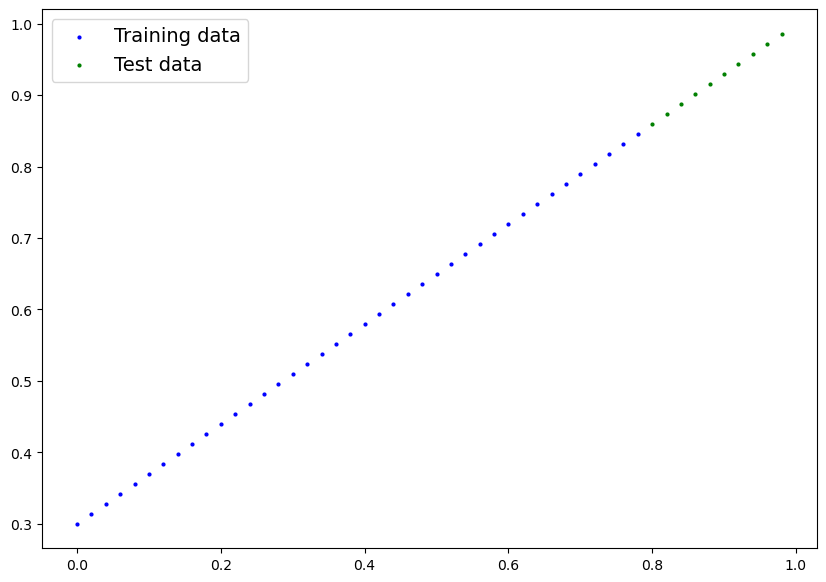

In [23]:
plot_predictions()

In [13]:
### Build the model
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, dtype=torch.float32, requires_grad=True)) # require_grad - as we want this value to be updated during training
        self.bias = nn.Parameter(torch.randn(1, dtype=torch.float32, requires_grad=True))

    def forward(self, x: torch.Tensor) -> torch.Tensor :
        return self.weights *  x + self.bias

In [38]:
##  Checking the contents of the pytorch model
torch.manual_seed(42)

# Creating an instance of the model
model_0 = LinearRegressionModel()

## Checking the nn.Parameters() within the nn.Module subclass that were created
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [15]:
## Getting the state of the model parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [16]:
#### making prediction using torch.inference_mode()

"""
Note: when using inference_mode as a context manager, it turns off a bunch of things

"""
with torch.inference_mode():
    y_preds = model_0(X_test)

In [19]:
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [17]:
### Note: we didn't actually train the model yet, but did a single forward pass, and can visualize how the lines look like

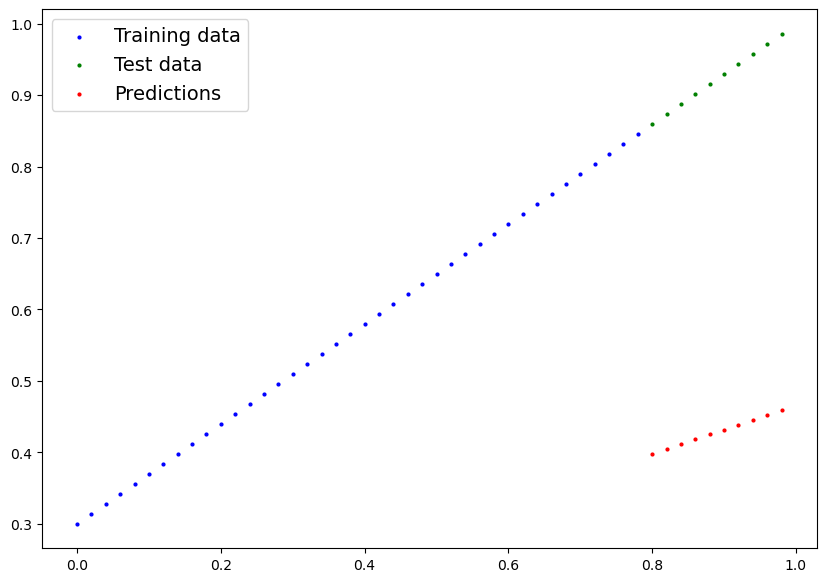

In [24]:
plot_predictions(predictions=y_preds)

In [25]:
# Technically we want the above red dots to be as closely aligned to the green dots just to make sure that the model has learned.

In [26]:
# Creating a loss function and optimizer
# Loss function - measure how wrong the model predictions are - eg: MAE for regression (L1lsss), Binary Cross-Entropy for Binary Classification
# Optimizer - tells the model how to update the interal params to best lower the loss - eg: torch.optim.SGD, Adam

In [39]:
# Create the loss function
loss_fn = nn.L1Loss() #MAE Loss is same as L1loss

# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

In [28]:
### Creating a optimization loop in pytorch

In [29]:
"""
Pytorch training loop

1. Forward pass - > model(train_data)
2. Calculate the loss -> loss = loss_fn(y_pred, y_train)
3. Zero gradients -> the optimizers gradients are set to zero, so that they can be    -> optimizer.zero_grad()
                     recalculated for a specific training step
4. Perform backprop on the loss -> computes the gradient of the loss wrt each model param to be updated -> loss.backward()
                                (i.e the ones with require_grad=Tuue)

5. Update the optimizer -> update the paramaters with respect to the loss gradients to improve them -> optimizer.step()                                
"""

'\nPytorch training loop\n\n1. Forward pass - > model(train_data)\n2. Calculate the loss -> loss = loss_fn(y_pred, y_train)\n3. Zero gradients -> the optimizers gradients are set to zero, so that they can be    -> optimizer.zero_grad()\n                     recalculated for a specific training step\n4. Perform backprop on the loss -> computes the gradient of the loss wrt each model param to be updated -> loss.backward()\n                                (i.e the ones with require_grad=Tuue)\n\n5. Update the optimizer -> update the paramaters with respect to the loss gradients to improve them -> optimizer.step()                                \n'

In [30]:
"""
Pytorch Testing Loop
i. Note for the testing - there will  be no backprop as no need to compute gradients of the loss
ii. Also we wont step through the optimizer - no need to update params

1. For each epoch [a full cycle across all the test data]
2. Tell the model we want to eval instead of train - train.eval()
3. Turn on the inference_mode() context manager - do disable gradient tracking
4. Pass the test data to the model - using the forward function
5. Calculate the test loss -> how wrong the predictions are , lower the better
"""

'\nPytorch Testing Loop\ni. Note for the testing - there will  be no backprop as no need to compute gradients of the loss\nii. Also we wont step through the optimizer - no need to update params\n\n1. For each epoch [a full cycle across all the test data]\n2. Tell the model we want to eval instead of train - train.eval()\n3. Turn on the inference_mode() context manager - do disable gradient tracking\n4. Pass the test data to the model - using the forward function\n5. Calculate the test loss -> how wrong the predictions are , lower the better\n'

In [40]:
torch.manual_seed(42)

epochs = 100

# Create emptu loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training

    # Put the model in training mode
    y_pred = model_0(X_train)

    # Calculate the loss
    loss = loss_fn(y_pred, y_train)

    # Zero grad of the optimizer
    optimizer.zero_grad()

    # Back-Prop
    loss.backward()

    # Progress the optimizer
    optimizer.step()

    ## Testing
    model_0.eval() # signal eval mode

    with torch.inference_mode():
        # 1. Forward pass on the test
        test_pred = model_0(X_test)

        test_loss = loss_fn(test_pred, y_test.type(torch.float32))

        ## Printing out what is happening
        if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch {epoch}, Train Loss {loss} , Test Loss {test_loss}")

Epoch 0, Train Loss 0.31288138031959534 , Test Loss 0.48106518387794495
Epoch 10, Train Loss 0.1976713240146637 , Test Loss 0.3463551998138428
Epoch 20, Train Loss 0.08908725529909134 , Test Loss 0.21729660034179688
Epoch 30, Train Loss 0.053148526698350906 , Test Loss 0.14464017748832703
Epoch 40, Train Loss 0.04543796554207802 , Test Loss 0.11360953003168106
Epoch 50, Train Loss 0.04167863354086876 , Test Loss 0.09919948130846024
Epoch 60, Train Loss 0.03818932920694351 , Test Loss 0.08886633068323135
Epoch 70, Train Loss 0.03476089984178543 , Test Loss 0.0805937647819519
Epoch 80, Train Loss 0.03132382780313492 , Test Loss 0.07232122868299484
Epoch 90, Train Loss 0.02788740023970604 , Test Loss 0.06473556160926819


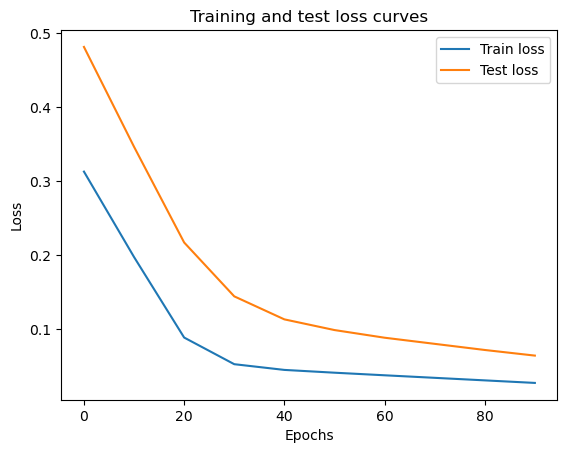

In [41]:
### Lets plot training loss against test loss
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [42]:
### Making predictions

model_0.eval()

with torch.inference_mode():
    # Make sure the calculations are done with model and data on the same device
    y_preds = model_0(X_test)
y_preds

tensor([[0.8141],
        [0.8256],
        [0.8372],
        [0.8488],
        [0.8603],
        [0.8719],
        [0.8835],
        [0.8950],
        [0.9066],
        [0.9182]])

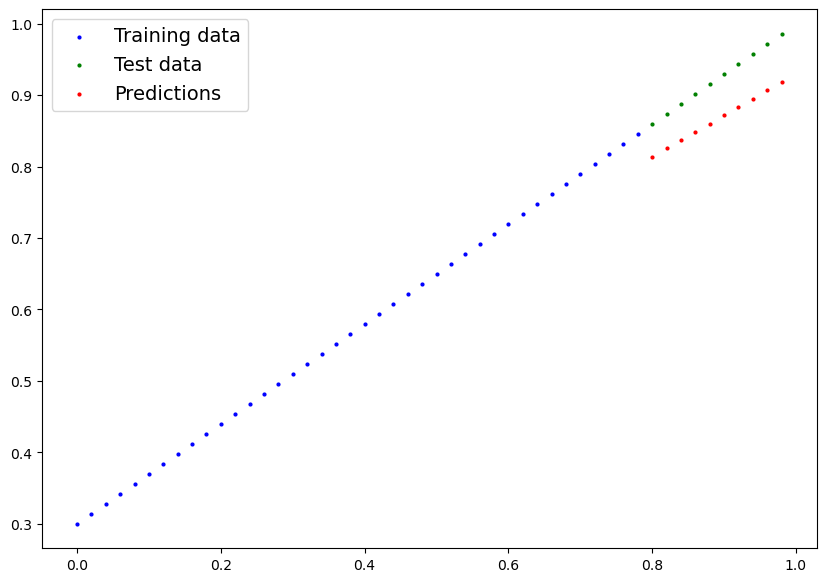

In [43]:
plot_predictions(predictions=y_preds)

In [45]:
### Saving and Loading the pytorch model
"""
torch.save -> saves a serialized object to disk using pickle 
torch.load -> deserializes and loads pythong pickled objects, we can also set which device to load the object to
torch.nn.Module.load_state_dict -> Loads a models parameter dictionary using a saved state_dict() object
""" 

'\ntorch.save -> saves a serialized object to disk using pickle \ntorch.load -> deserializes and loads pythong pickled objects, we can also set which device to load the object to\ntorch.nn.Module.load_state_dict -> Loads a models parameter dictionary using a saved state_dict() object\n'

In [50]:
from pathlib import Path

# Create the models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)


Saving model to: models/01_pytorch_workflow_model_0.pth


In [ ]:
## Loading the saved PyTorch Model
# we can load a model using - torch.nn.Module.load_state_dict(nn.load(<model path>))
# Note: we are using nn.load inside load_state_dict, since we only saved the state_dict
# we first need to load the state_dict with torch.load and then pass the state_dict to the new instance of the model.

In [52]:
loaded_model_0 = LinearRegressionModel()

# Loading the state_dict
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [53]:
### Now that we are done loading the saved model, we will now apply inference
loaded_model_0.eval()

with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)

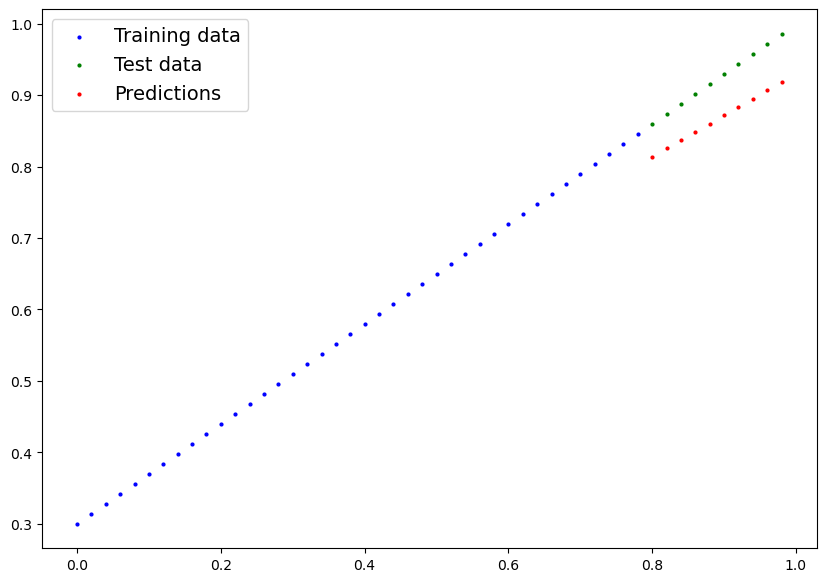

In [54]:
plot_predictions(predictions=loaded_model_preds)

In [55]:
### Putting it all together

In [56]:
import torch
import matplotlib.pyplot as plt

torch.__version__

'1.13.1'

In [57]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [58]:
# Subclass nn.Module to make our model
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear() for creating the model parameters
        self.linear_layer = nn.Linear(in_features=1, 
                                      out_features=1)
    
    # Define the forward computation (input data x flows through nn.Linear())
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

# Set the manual seed when creating the model (this isn't always need but is used for demonstrative purposes, try commenting it out and seeing what happens)
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()


(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [59]:
## Training Loss and Optimizer

# Create loss function
loss_fn = nn.L1Loss()

# Create optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), # optimize newly created model's parameters
                            lr=0.01)


In [60]:
## Training

torch.manual_seed(42)

# Set the number of epochs 
epochs = 1000 

# Put data on the available device
# Without this, error will happen (not all model/data on device)
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_1.train() # train mode is on by default after construction

    # 1. Forward pass
    y_pred = model_1(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad optimizer
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    ### Testing
    model_1.eval() # put the model in evaluation mode for testing (inference)
    # 1. Forward pass
    with torch.inference_mode():
        test_pred = model_1(X_test)
    
        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Train loss: 0.5551779866218567 | Test loss: 0.5739762187004089
Epoch: 100 | Train loss: 0.006215679459273815 | Test loss: 0.014086711220443249
Epoch: 200 | Train loss: 0.0012645028764382005 | Test loss: 0.013801807537674904
Epoch: 300 | Train loss: 0.0012645028764382005 | Test loss: 0.013801807537674904
Epoch: 400 | Train loss: 0.0012645028764382005 | Test loss: 0.013801807537674904
Epoch: 500 | Train loss: 0.0012645028764382005 | Test loss: 0.013801807537674904
Epoch: 600 | Train loss: 0.0012645028764382005 | Test loss: 0.013801807537674904
Epoch: 700 | Train loss: 0.0012645028764382005 | Test loss: 0.013801807537674904
Epoch: 800 | Train loss: 0.0012645028764382005 | Test loss: 0.013801807537674904
Epoch: 900 | Train loss: 0.0012645028764382005 | Test loss: 0.013801807537674904


In [61]:
# Find our model's learned parameters
from pprint import pprint # pprint = pretty print, see: https://docs.python.org/3/library/pprint.html 
print("The model learned the following values for weights and bias:")
pprint(model_1.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('linear_layer.weight', tensor([[0.6968]])),
             ('linear_layer.bias', tensor([0.3025]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


In [62]:
### Making the prediction

# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
    y_preds = model_1(X_test)
y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]])

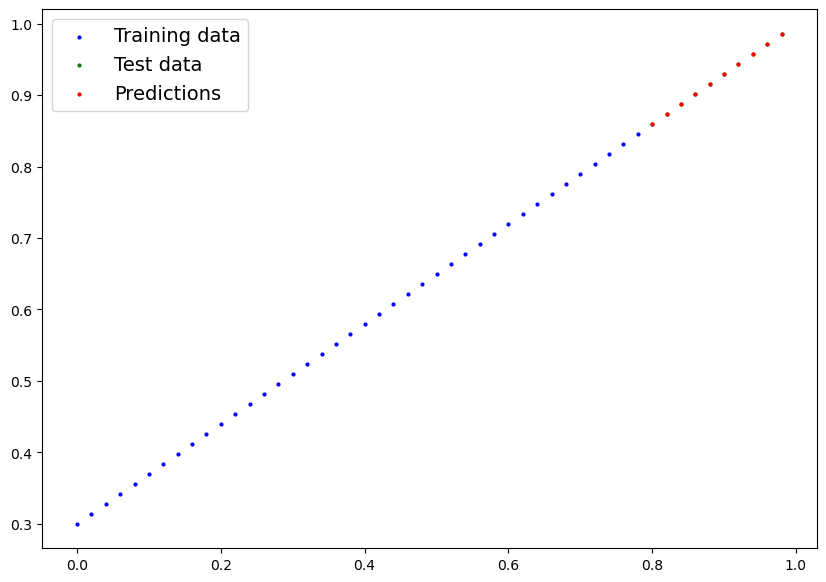

In [63]:
# Put data on the CPU and plot it
plot_predictions(predictions=y_preds)

In [ ]:
## Saving an Loading the model

In [64]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 

Saving model to: models/01_pytorch_workflow_model_1.pth


In [65]:
## Loading the model

# Instantiate a fresh instance of LinearRegressionModelV2
loaded_model_1 = LinearRegressionModelV2()

# Load model state dict 
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_1.to(device)

print(f"Loaded model:\n{loaded_model_1}")
print(f"Model on device:\n{next(loaded_model_1.parameters()).device}")

Loaded model:
LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
Model on device:
cpu


In [66]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

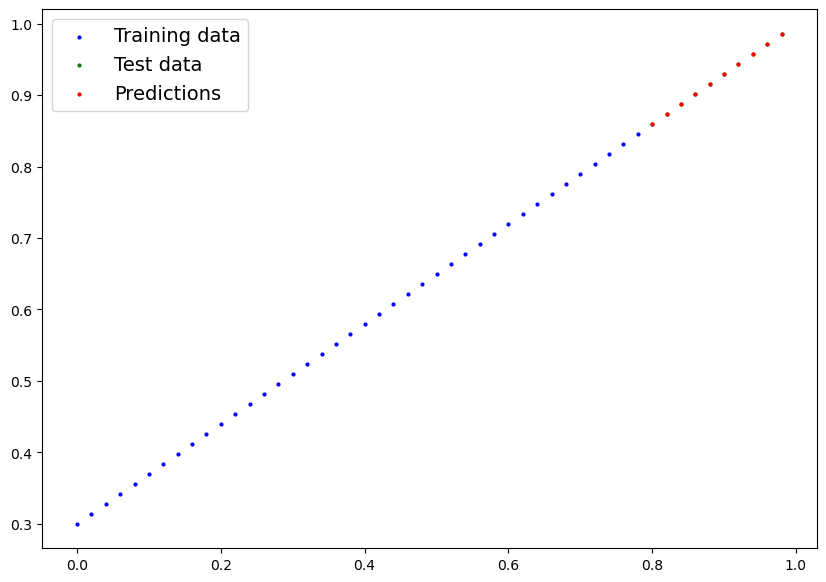

In [67]:
plot_predictions(predictions=loaded_model_1_preds)